In [57]:
import numpy as np
import os
from cv2 import imread, resize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [58]:
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

In [59]:
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5)  # count for loading folders for 5 classes
    train_data = []
    val_data = []

    # when ablation is None, pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            label = int(doc.strip().split(';')[2])
            if counts[label] < ablation:
                train_data.append(doc)
                counts[label] += 1

        counts = np.zeros(5)

        # iterating val doc
        for doc in val_doc:
            label = int(doc.strip().split(';')[2])
            if counts[label] < ablation:
                val_data.append(doc)
                counts[label] += 1
    else:
        train_data, val_data = train_doc, val_doc

    return train_data, val_data

ABLATION and PARAMETERS

In [60]:
train_doc, val_doc = get_data('Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = list(range(30))
# image dimensions
dim_x, dim_y = 120, 120

In [61]:
# generator without augmentation and cropping for train data
def generator(source_path, folder_list, batch_size):
    img_idx = seq_idx  # create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)

        if (len(t) % batch_size) == 0:
            num_batches = int(len(t) / batch_size)
        else:
            num_batches = len(t) // batch_size + 1

        for batch in range(num_batches):  # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, 3))  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5))  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):  # iterate over the batch_size
                # handling remaining datapoints
                folder_idx = folder + (batch * batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path + '/' + folder_str.split(';')[0])  # read all the images in the folder

                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path + '/' + folder_str.strip().split(';')[0] + '/' + imgs[item]).astype(
                        np.float32)

                    # resize the images. Note that the images are of 2 different shapes
                    # and the conv3D will throw an error if the inputs in a batch have different shapes
                    resized_im = resize(image, dsize=(y, z))

                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels  # you yield the batch_data and the batch_labels


C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_18196\1711043712.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(r"Project_data\train\WIN_20180907_15_35_09_Pro_Right Swipe_new\WIN_20180907_15_35_09_Pro_00012.png")
C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_18196\1711043712.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(r"Project_data\train\WIN_20180907_15_35_09_Pro_Right Swipe_new\WIN_20180907_15_35_09_Pro_00014.png")


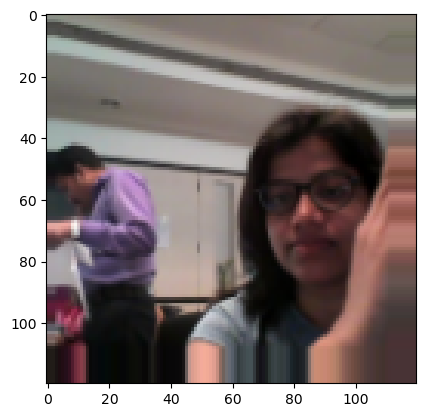

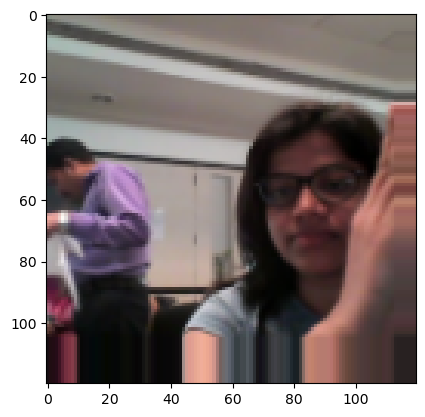

In [5]:
from keras.preprocessing.image import ImageDataGenerator
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread(r"Project_data\train\WIN_20180907_15_35_09_Pro_Right Swipe_new\WIN_20180907_15_35_09_Pro_00012.png")
#160 by 120
image2 = imageio.imread(r"Project_data\train\WIN_20180907_15_35_09_Pro_Right Swipe_new\WIN_20180907_15_35_09_Pro_00014.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()



def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


EPOCH

In [62]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  'Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [63]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras import regularizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)

MODEL 1

In [64]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(5, activation='softmax'))

MODEL 2

In [65]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(5, activation='softmax'))

MODEL 3

In [66]:
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.25))

model.add(GlobalAveragePooling3D())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


In [67]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 28, 118, 118, 32   2624      
                             )                                   
                                                                 
 batch_normalization_8 (Bat  (None, 28, 118, 118, 32   128       
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 14, 59, 59, 32)    0         
 g3D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 14, 59, 59, 32)    0         
                                                                 
 global_average_pooling3d_4  (None, 32)                0         
  (GlobalAveragePooling3D)                            

CALLBACKS

In [68]:
model_name = 'model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

# earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

callbacks_list = [checkpoint, LR]

DATAGEN

In [69]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [70]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

TRAIN

In [71]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 6.0793 - categorical_accuracy: 0.2500 
Epoch 1: saving model to model_3_2024-03-0219_33_49.751708\model-00001-6.07928-0.25000-5.18815-0.14062.h5
21/21 [==============================] - 866s 41s/step - loss: 6.0793 - categorical_accuracy: 0.2500 - val_loss: 5.1881 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 5.2009 - categorical_accuracy: 0.3884 
Epoch 2: saving model to model_3_2024-03-0219_33_49.751708\model-00002-5.20088-0.38839-4.75949-0.16406.h5
21/21 [==============================] - 858s 41s/step - loss: 5.2009 - categorical_accuracy: 0.3884 - val_loss: 4.7595 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 4.7974 - categorical_accuracy: 0.3929 
Epoch 3: saving model to model_3_2024-03-0219_33_49.751708\model-00003-4.79737-0.39286-4.38599-0.13281.h5
21/21 [==================

EVALUATE

NameError: name 'history' is not defined

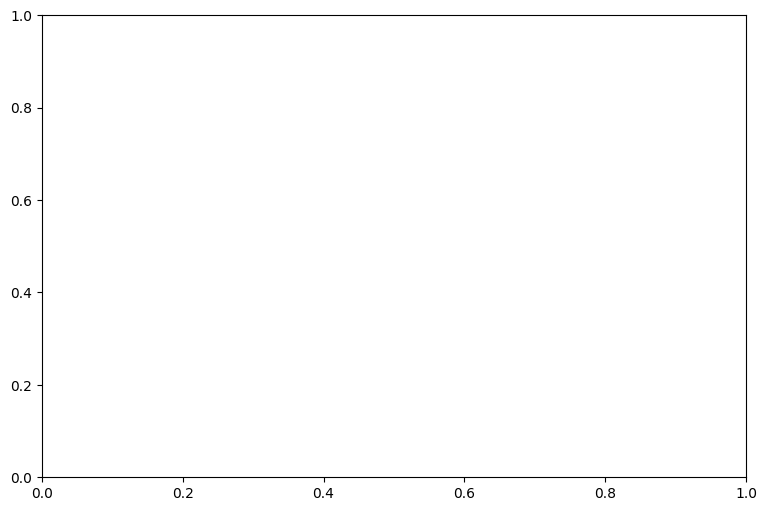

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')